In [1]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [2]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load data

In [3]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
#path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path

'M06_th45/'

In [4]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

### transform frame

In [5]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields
dflow = ft.transform_flow(dflow,vshock)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


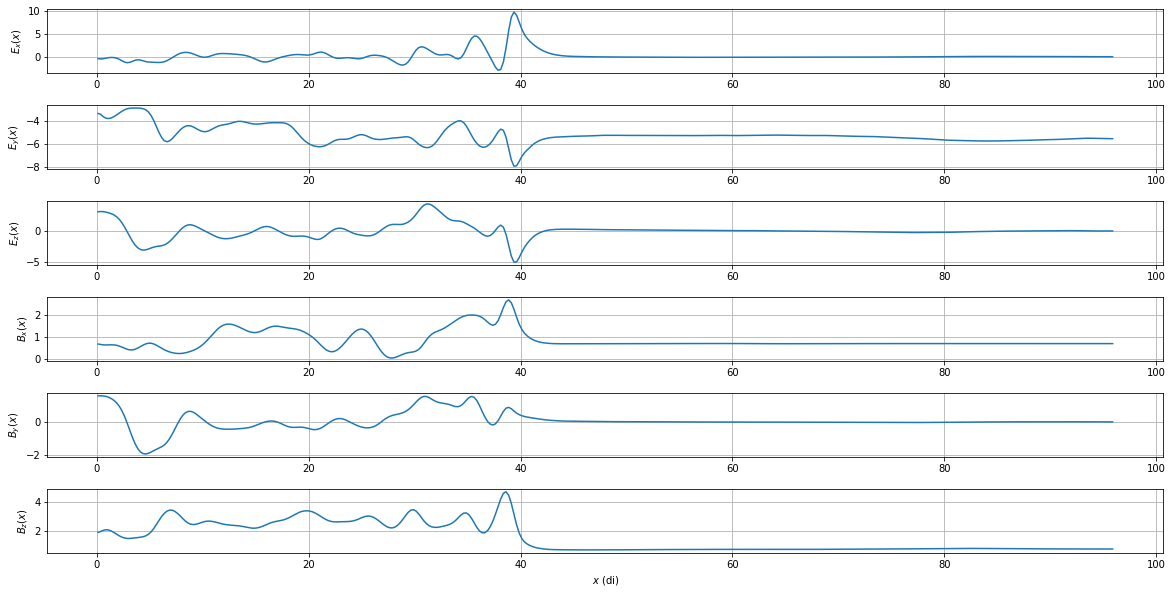

In [6]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### select x region to analyze

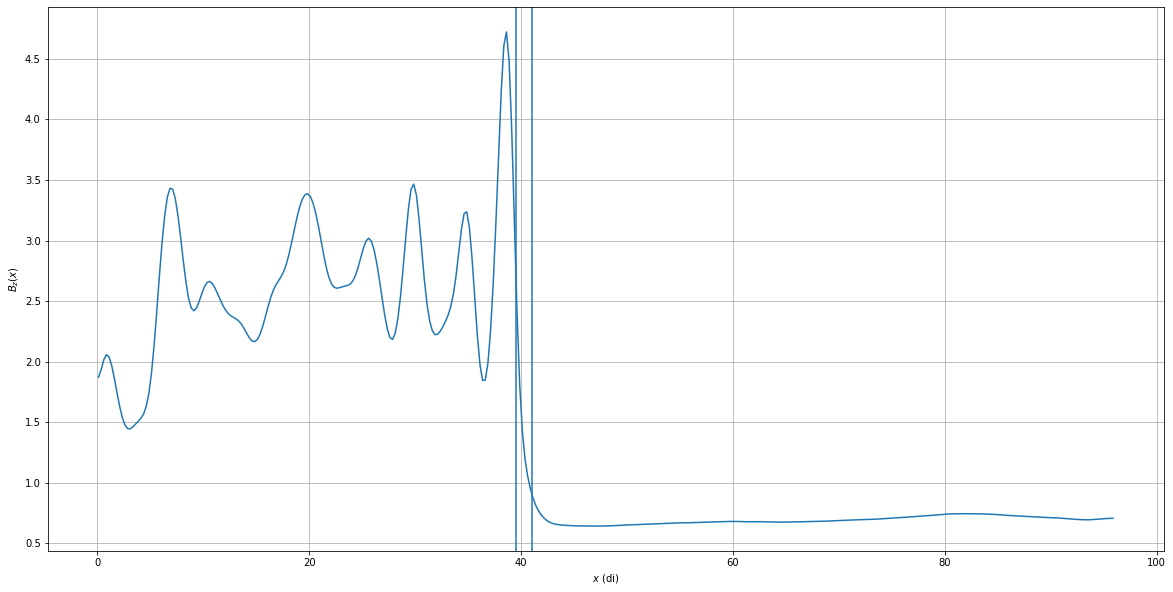

In [7]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startvalramp = 39.5#lower bound for metadata = 1 (di)
endvalramp = 41. #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startvalramp, axvx2 = endvalramp)

### get fluctuations

In [8]:
dflow.keys()

dict_keys(['ux', 'ux_xx', 'ux_yy', 'ux_zz', 'uy', 'uy_xx', 'uy_yy', 'uy_zz', 'uz', 'uz_xx', 'uz_yy', 'uz_zz', 'id', 'Vframe_relative_to_sim'])

In [9]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)
dflowfluc = anl.remove_average_flow_over_yz(dflow)

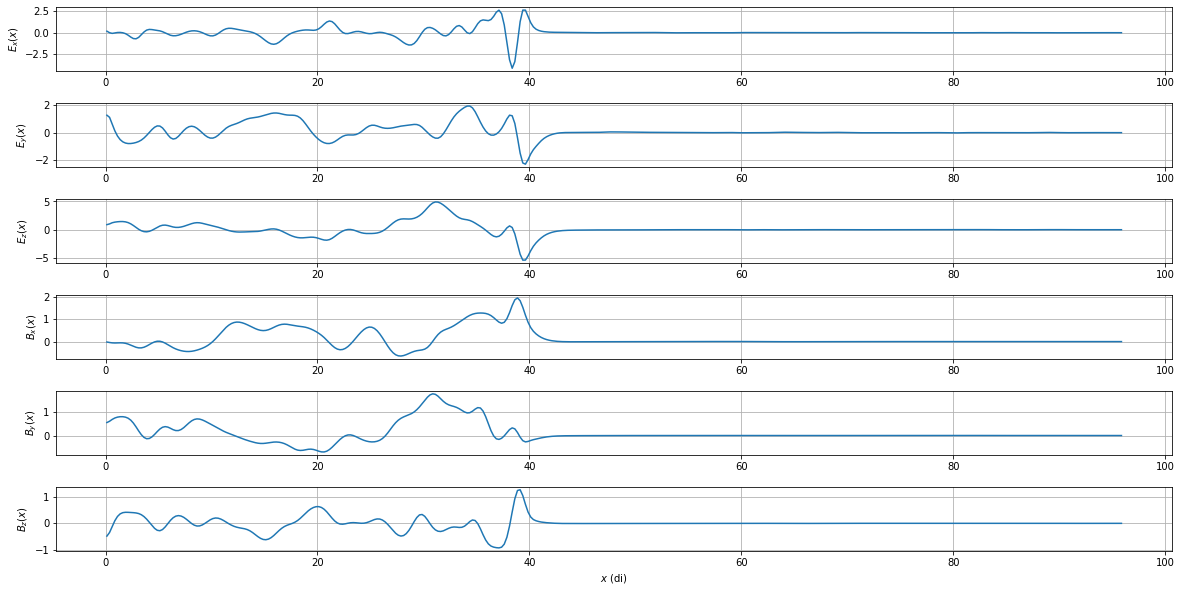

In [10]:
plt1d.plot_all_fields(dfieldsfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### get relevant subset

In [11]:
dfieldssubset = ao.get_field_subset(dfields,startvalramp,endvalramp,0.,12.,0.,12.)
dflowsubsset = ao.get_flow_subset(dflow,startvalramp,endvalramp,0.,12.,0.,12.)

dfieldflucsubset = ao.get_field_subset(dfieldsfluc,startvalramp,endvalramp,0.,12.,0.,12.)
dflowflucsubsset = ao.get_flow_subset(dflowfluc,startvalramp,endvalramp,0.,12.,0.,12.)

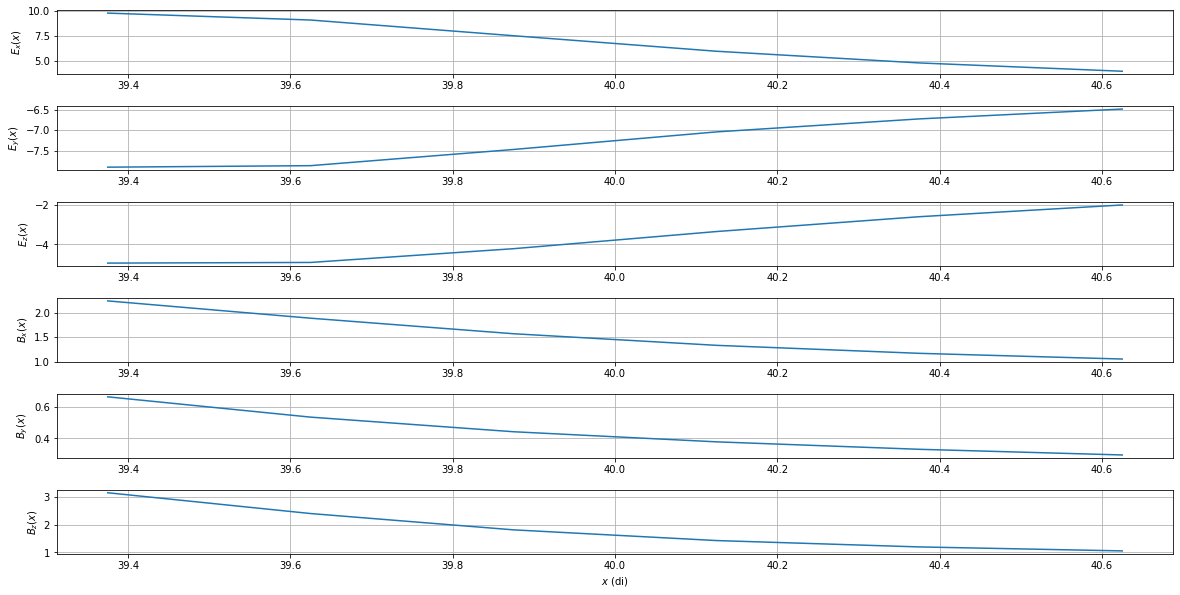

In [12]:
plt1d.plot_all_fields(dfieldssubset, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Take FFT

In [13]:
fftbx = np.fft.fftn(dfieldssubset['bx'])
fftby = np.fft.fftn(dfieldssubset['by'])
fftbz = np.fft.fftn(dfieldssubset['bz'])
fftex = np.fft.fftn(dfieldflucsubset['ex'])
fftey = np.fft.fftn(dfieldflucsubset['ey'])
fftez = np.fft.fftn(dfieldflucsubset['ez'])
fftux = np.fft.fftn(dflowflucsubsset['ux'])
fftuy = np.fft.fftn(dflowflucsubsset['uy'])
fftuz = np.fft.fftn(dflowflucsubsset['uz'])

In [14]:
fftB = np.asarray([np.max(fftbx),np.max(fftby),np.max(fftbz)])

In [15]:
print(fftB)

[ 9331.44998456+0.j  8730.85597813+0.j 18508.28511959+0.j]


In [16]:
indbx = np.unravel_index(np.argmax(fftbx, axis=None), fftbx.shape)
indby = np.unravel_index(np.argmax(fftby, axis=None), fftby.shape)
indbz = np.unravel_index(np.argmax(fftbz, axis=None), fftbz.shape)
print(indbx,indby,indbz)

(0, 0, 0) (0, 0, 0) (0, 0, 0)


In [17]:
index = np.unravel_index(np.argmax(fftex, axis=None), fftex.shape)
indey = np.unravel_index(np.argmax(fftey, axis=None), fftey.shape)
indez = np.unravel_index(np.argmax(fftez, axis=None), fftez.shape)
print(index,indey,indez)

(45, 46, 0) (46, 46, 0) (44, 45, 1)


In [18]:
b0 = [np.mean(dfieldssubset['bx']),np.mean(dfieldssubset['by']),np.mean(dfieldssubset['bz'])]
b0squared = np.dot(b0,b0)

In [19]:
b0squared

2.8796306

In [20]:
def compare_drift_to_flow(id1,id2,id3,fftbx,fftby,fftbz,fftex,fftey,fftez,fftux,fftuy,fftuz,b0squared):
    dbx = fftbx[id1][id2][id3]
    dby = fftby[id1][id2][id3]
    dbz = fftbz[id1][id2][id3]
    dex = fftex[id1][id2][id3]
    dey = fftey[id1][id2][id3]
    dez = fftez[id1][id2][id3]
    dux = fftux[id1][id2][id3]
    duy = fftuy[id1][id2][id3]
    duz = fftuz[id1][id2][id3]
    
    du_drift = np.cross([0,dey,dez],[dbx,dby,dbz])/b0squared
    #du_drift = np.cross([0,dey,dez],[dbx,dby,dbz])/(np.dot([dbx,dby,dbz],[dbx,dby,dbz]))
    du_measured = [dux,duy,duz]
    
    return du_drift, du_measured
    

In [21]:
id1 = 45
id2 = 46
id3 = 0
compare_drift_to_flow(id1,id2,id3,fftbx,fftby,fftbz,fftex,fftey,fftez,fftux,fftuy,fftuz,b0squared)

(array([ -9739998.93913666+4506211.84164337j,
        -16856813.57533456+5874563.42936335j,
         10373285.94987799-4581581.31121584j]),
 [(-607.7030337855816+7902.949299662344j),
  (-1115.4211712860842-2869.9324293183827j),
  (-545.9772045616188+654.7731022044279j)])

In [22]:
fftex[46][46][0]

(-925.9200381346022-2417.222591593779j)

### Wavelet transform over x

In [23]:
#first calculate Bi(x,ky,kz) (or Ei(x,ky,kz))
fieldkey = 'bz'

#spacing in grids, needed to get wavenumber from fft
daxis0 = dfieldsfluc[fieldkey+'_zz'][1]-dfieldsfluc[fieldkey+'_zz'][0]
daxis1 = dfieldsfluc[fieldkey+'_yy'][1]-dfieldsfluc[fieldkey+'_yy'][0]

fieldfftsweepoverx = []
for xxindex in range(0,len(dfieldsfluc[fieldkey][0][0])):
    fieldslice = np.asarray(dfieldsfluc[fieldkey])[:,:,xxindex]
    ky, kz, fieldslicefft = anl.take_fft2(fieldslice,daxis0,daxis1)
    fieldfftsweepoverx.append(fieldslicefft)
fieldfftsweepoverx = np.asarray(fieldfftsweepoverx)

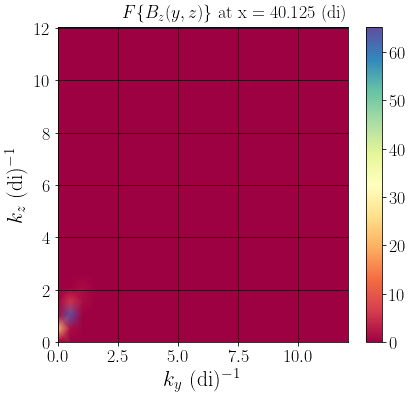

In [24]:
#plot fft in middle of ramp
midrampx = (startvalramp+endvalramp)/2.
midrampidx = ao.find_nearest(dfieldsfluc[fieldkey+'_xx'],midrampx)
pltfr.plot_fft_norm(dfields, fieldkey,'yz', takeaxisaverage=False, xxindex=midrampidx, plotlog=False) 
#TODO: plot over all positive and negative ky, kz
#TODO: limit domain of plot; i.e. zoom in on origin

In [25]:
kyidx, kzidx = np.unravel_index(np.argmax(fieldfftsweepoverx[midrampidx], axis=None), fieldfftsweepoverx[midrampidx].shape)

In [26]:
# #pick ky, kz using above plot
# kyidx = ao.find_nearest(ky,1.)
# kzidx = ao.find_nearest(kz,1.)

In [27]:
#take slice at given ky kz
xkykzdata = fieldfftsweepoverx[:,kyidx,kzidx] #TODO: Double check if ky and kz should be flipped

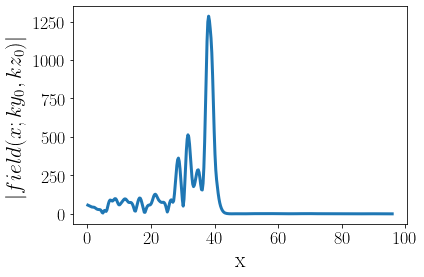

In [28]:
#plot norm
import matplotlib.pyplot as plt
temp = np.absolute(xkykzdata)
plt.figure()
plt.ylabel('$|field(x;ky_0,kz_0)|$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

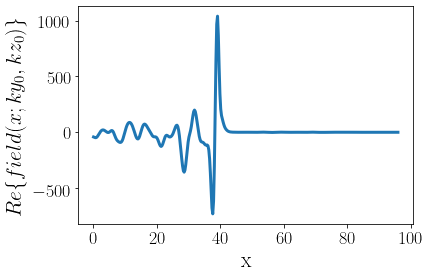

In [104]:
#plot real component
import matplotlib.pyplot as plt
temp = np.real(xkykzdata)
plt.figure()
plt.ylabel('$Re\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

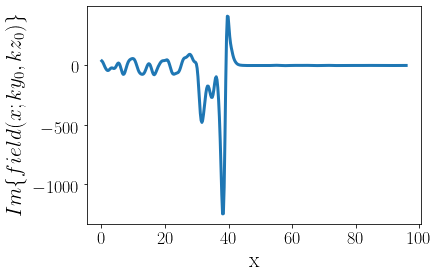

In [103]:
#plot imag component
import matplotlib.pyplot as plt
temp = np.imag(xkykzdata)
plt.figure()
plt.ylabel('$Im\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

In [31]:
#break up to real and imaginary parts
realxkykzdata = np.real(xkykzdata)
imagxkykzdata = np.imag(xkykzdata)
#WARNING signal.cwt DOESNT SEEM TO HANDLE COMPLEX NUMBERS
#we try breaking it up to real and imaginary parts. TODO: check if this is mathematically correct (i think so)

In [95]:
#take continuous wavelet transform of data
from scipy import signal
def morlet2(M,s,w=5): #hacky way to redefine default parameter for morlet2 function
    return signal.morlet2(M,s,w=w)
widths = np.linspace(.01 , 25, 5000)
wlt = signal.cwt(xkykzdata,signal.morlet2,widths) 
#imagwlt = signal.cwt(imagxkykzdata,signal.morlet2,widths)

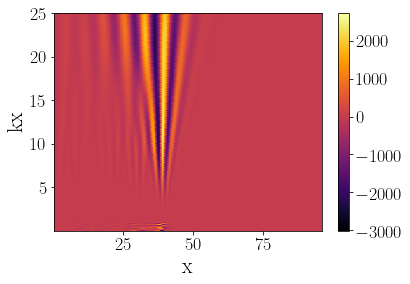

In [96]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],widths,np.real(wlt))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
#plt.xlim(startvalramp+5,endvalramp+5)
plt.show()

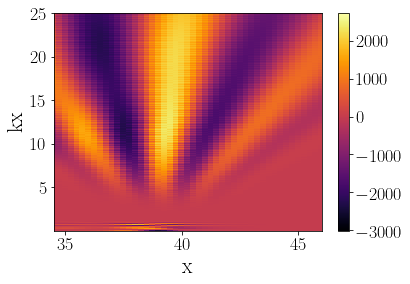

In [97]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],widths,np.real(wlt))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
plt.xlim(startvalramp-5,endvalramp+5)
plt.show()

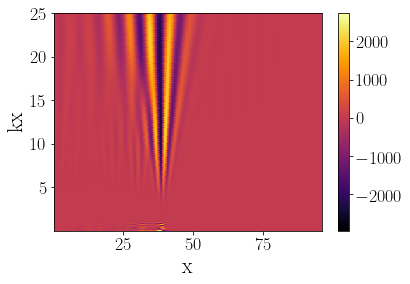

In [98]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],widths,np.imag(wlt))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
plt.show()

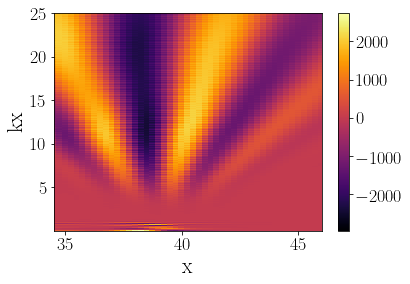

In [99]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],widths,np.imag(wlt))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
plt.xlim(startvalramp-5,endvalramp+5)
plt.show()

In [100]:
#widths = np.linspace(.01, 5, 5000)
testfieldavg = np.mean(dfieldsfluc['bz'],axis=(0,1))
wlttest = signal.cwt(dfieldsfluc['bz'][0,0,:],signal.morlet2,widths) 
#wlttest = signal.cwt(testfieldavg,signal.morlet2,widths) 


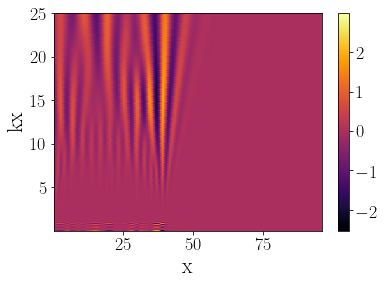

In [101]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],widths,np.real(wlttest))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
#plt.xlim(startvalramp-5,endvalramp+5)
plt.show()

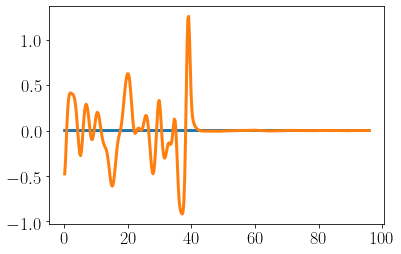

In [102]:
plt.figure()
plt.plot(dfields['bz_xx'],testfieldavg)
plt.plot(dfields['bz_xx'],dfieldsfluc['bz'][0,0,:])
plt.show()